# Food Vision Big

In [ ]:
! nvidia-smi

Fri Mar  3 15:33:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |    335MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# use mixed precision training to speed up the GPU computation by 3x
# is beneficial when GPU compute capability is above 7.0

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2e1d636c-9e5d-5e00-3e24-1feea8044a5c)


In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-03 15:33:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-03 15:33:42 (115 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [68]:
from helper_functions import (create_tensorboard_callback,
                              plot_loss_curves,
                              compare_historys)
import tensorflow as tf
import numpy as np

In [ ]:
# use tfds to get data
# gives data directly in the form of tensors

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
datasets = tfds.list_builders()
len(datasets)

1138

In [ ]:
print("food101" in datasets)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True, 
                                             as_supervised=True, # data gets returned in tuple format (data, label),
                                             with_info=True)

## Become one with data
### class names
### shape of input
### datatype of input
### labels (one-hot encoded or label encoded)
### labels match with class names? 

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo n

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# take one sample
train_data_sample = train_data.take(1)
train_data_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# output information about our sample
for image, label in train_data_sample:
  print(f""" 
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]} 
  """)

 
  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup 
  


In [ ]:
# we see from the label, that the labels are NOT one hot encoded

In [ ]:
# min and max values of image tensor
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(0, 255)

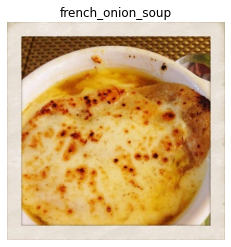

In [47]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis("off")
plt.show()

In [77]:
# function for preprocessing images
def preprocess_image(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [79]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_image(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[136 101  82]
  [138 103  84]
  [138 103  83]
  ...
  [154 118  94]
  [151 115  91]
  [149 113  87]]

 [[139 104  84]
  [141 106  86]
  [141 106  86]
  ...
  [151 115  89]
  [151 115  89]
  [152 117  89]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[138.64285  103.64286   84.      ]
  [139.78572  104.78571   84.64286 ]
  [137.92857  103.43367   79.918365]
  ...
  [152.64287  116.28572   95.357155]
  [152.16835  116.14284   91.168274]
  [150.95409  115.36735   88.79592 ]]

 [[129.21428   98.14285   70.448975]
  [132.35204  101.28571   72.55612 ]
  [133.07144  102.07143   73.14285 ]
  ...
  [159.15819  125.65817   94.76021 ]
  [161.63776  127.49492   93.071396]
  [162.40306  128.33163   92.40307 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


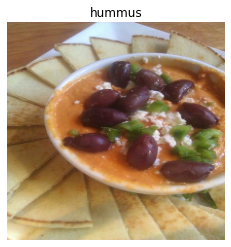

In [83]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib compatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);